In [5]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = "C:/Users/se7en/Desktop/dd/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
size = 80

pre_trained_model = InceptionV3(input_shape = (size, size,3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False


In [ ]:
# pre_trained_model.summary()

In [9]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 3, 3, 768)


In [10]:
from tensorflow.keras.optimizers import RMSprop

x = layers.GlobalAveragePooling2D()(last_output)
# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.7)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_dir = 'img_data'

# train_dir = os.path.join( base_dir, 'train')
# validation_dir = os.path.join( base_dir, 'validation')


# train_drowsiness_dir = os.path.join(train_dir, 'drowsiness') # Directory with our training drowsiness pictures
# train_undrowsiness_dir = os.path.join(train_dir, 'undrowsiness') # Directory with our training undrowsiness pictures
# validation_drowsiness_dir = os.path.join(validation_dir, 'drowsiness') # Directory with our validation drowsiness pictures
# validation_undrowsiness_dir = os.path.join(validation_dir, 'undrowsiness')# Directory with our validation undrowsiness pictures

# train_drowsiness_fnames = os.listdir(train_drowsiness_dir)
# train_undrowsiness_fnames = os.listdir(train_undrowsiness_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   brightness_range=None,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   channel_shift_range=0.0,
                                   fill_mode="nearest",
                                   horizontal_flip = True,
                                   validation_split=0.15,)

# Note that the validation data should not be augmented!
# test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(base_dir,
                                                    subset = 'training',
                                                    shuffle=True,
                                                    batch_size = 30,
                                                    class_mode = 'binary', 
                                                    target_size = (size, size))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  train_datagen.flow_from_directory(base_dir,
                                                          shuffle=True,
                                                          subset = 'validation',
                                                          batch_size  = 10,
                                                          class_mode  = 'binary', 
                                                          target_size = (size, size))
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(train_generator.classes)

Found 1908 images belonging to 2 classes.
Found 335 images belonging to 2 classes.
{'drowsiness': 0, 'undrowsiness': 1}
{'drowsiness': 0, 'undrowsiness': 1}
[0 0 0 ... 1 1 1]


In [12]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 5,
            verbose = 1)

Epoch 1/5
64/64 [==============================] - 152s 2s/step - loss: 0.6567 - accuracy: 0.6132 - val_loss: 0.6264 - val_accuracy: 0.6388
Epoch 2/5
64/64 [==============================] - 102s 2s/step - loss: 0.5901 - accuracy: 0.6468 - val_loss: 0.6213 - val_accuracy: 0.6478
Epoch 3/5
64/64 [==============================] - 60s 933ms/step - loss: 0.5555 - accuracy: 0.6944 - val_loss: 0.5936 - val_accuracy: 0.6687
Epoch 4/5
64/64 [==============================] - 80s 1s/step - loss: 0.5326 - accuracy: 0.7301 - val_loss: 0.5716 - val_accuracy: 0.6955
Epoch 5/5
64/64 [==============================] - 100s 2s/step - loss: 0.4909 - accuracy: 0.7552 - val_loss: 0.5705 - val_accuracy: 0.6896


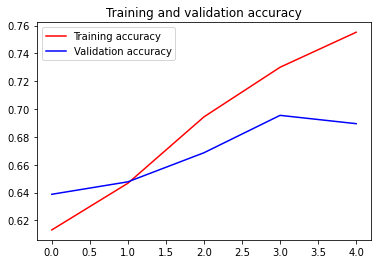

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [17]:
model.save('model_13Nov_3epoch_tf_smooth.h5')

In [14]:
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
face_cascade = cv2.CascadeClassifier("data/haarcascade_frontalface_alt.xml")
label = ["dr","udr"]
import numpy as np

# image = cv2.imread("test.jpg")

# image = tf.image.decode_jpeg("test.jpg")
# image = tf.cast(image, tf.float32)
plt.imshow(image)
plt.show()
img_array = img_to_array(image)
img_array = np.array(img_array,dtype='uint8')
# img = cv2.imshow('test.jpg')
gray = cv2.cvtColor(img_array,cv2.COLOR_BGR2GRAY)
gray = np.array(gray, dtype='uint8')
# gray = cv2.fastNlMeansDenoisingColored(gray,None,10,10,7,21)
faces = face_cascade.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 5)
for (x,y,w,h) in faces:
#         print(x,y,w,h)
    roi_image = img_array[y:y+h,x:x+w]

    roi_image = cv2.resize(roi_image, (size,size))
    roi_image = cv2.fastNlMeansDenoisingColored(roi_image,None,10,10,7,21)
#     roi_image = tf.cast(roi_image, tf.float32)
    roi_image = np.array(roi_image,dtype='uint8')
#     roi_image = roi_image.astype('float32')
    p = model.predict([roi_image.reshape((1,size,size,3))])
    print(p)


# def makeimage(path):
#     frame = load_img(path,target_size = (size,size))
#     frame = img_to_array(frame)
#     return np.array([frame])


# def prepare(path):
#     size = 150
#     img_array = cv2.imread(path)
#     gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    
#     faces = face_cascade.detectMultiScale(gray, scaleFactor = 1.2, minNeighbors = 7)
#     for (x,y,w,h) in faces:
# #         print(x,y,w,h)
#         roi_image = img_array[y:y+h,x:x+w]
        
#         roi_image = cv2.resize(roi_image, (size,size))
#         roi_image = cv2.fastNlMeansDenoisingColored(roi_image,None,10,10,7,21)
#         roi_image = np.array([roi_image],'float64')
# #         plt.imshow(roi_image,cmap='binary')
# #         plt.show()
# #         print(roi_image.shape)
#         return roi_image.reshape((1,150,150,3))
#     img_array = cv2.resize(img_array , (size,size))
#     return img_array.reshape((1,150,150,3))
# p = model.predict(prepare('test.jpg'))
# print(p)

InvalidArgumentError: Expected image (JPEG, PNG, or GIF), got unknown format starting with 'test.jpg' [Op:DecodeJpeg]

In [16]:
import cv2
cap = cv2.VideoCapture(0)
label = "Test"
count = 0
size = 150
labels = ["drowsiness" , "undrowsiness"]
face_cascade = cv2.CascadeClassifier("data/haarcascade_frontalface_alt.xml")
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
#     rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     rgb_img = cv2.resize(rgb_img,(size,size))
#     rgb_img = rgb_img.reshape((1,size,size,3))
#     class_index = model.predict([rgb_img])[0][0]
#     label = labels[int(class_index)]

    # Our operations on the frame come here
#     frame = cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21)
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 5)
    for (x,y,w,h) in faces:
#         print(x,y,w,h)
        roi_image = frame[y:y+h,x:x+w]
        
        roi_image = cv2.resize(roi_image , (size , size))
        pre = model.predict([roi_image.reshape((1,150,150,3))])
        color = (0,45,255)
        stroke = 2
        end_x = x+w
        end_y = y+h
        cv2.rectangle(frame, (x,y), (end_x,end_y), color, stroke)
        label = labels[int(pre[0][0])]
        print(label,pre)

    cv2.putText(frame,label, (5,450), cv2.FONT_HERSHEY_SIMPLEX, 2, (250,255,255))
    cv2.imshow('frame',frame)
    count+=1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()


error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-2b5g8ysb\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [18]:
import matplotlib.pyplot as plt 
import numpy as np
import random
import tensorflow as tf
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

d_dir = "img_data/drowsiness"
ud_dir = "img_data/undrowsiness"
d_img = os.listdir(d_dir)
ud_img = os.listdir(ud_dir)
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
d_img_files = [os.path.join(d_dir, f) for f in d_img]
ud_img_files = [os.path.join(ud_dir, f) for f in ud_img]

img_path = random.choice(d_img_files + ud_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

ValueError: could not broadcast input array from shape (74,74) into shape (10,10)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
